In [459]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm
import matplotlib.gridspec as gridspec
from factanal.wrapper import factanal
import json
import seaborn as sns

import geopandas as gp
import descartes
# import geoplot

# import geoplot.crs as gcrs

from scipy import signal
from sklearn.decomposition import FastICA, PCA
from sklearn.linear_model import Lasso
from scipy.stats import zscore
from sklearn.preprocessing import PowerTransformer

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.decomposition import non_negative_factorization, NMF
from matplotlib.ticker import PercentFormatter

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [460]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [461]:
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [683]:
def scree_plot(ev,df):    
    plt.plot(range(1,df.shape[1]+1),ev,'-o',color='b')
    plt.title('Scree Plot')
    plt.xlabel('Number of factors')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1,c='r')
    plt.show();
       
def perform_fa(df, NUM, rotation, scores_method, method):
    
    fa = factanal(df, factors=NUM, scores=scores_method, rotation=rotation,  #'Bartlett','regression'
                  verbose=True, return_dict=True)
    
#     fa = FactorAnalyzer(n_factors=NUM, rotation=rotation, method=method) 
#     fa.fit(df)
    return fa


def loadings_plot(Loadings, col_names):
    fig, ax = plt.subplots(figsize=(8,8))
    c = ax.pcolor(abs(Loadings))
    fig.colorbar(c, ax=ax)
    ax.set_yticks(np.arange(Loadings.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(Loadings.shape[1])+0.5, minor=False)
    ax.set_yticklabels(col_names)
    ax.set_xticklabels(['Factor '+str(i+1) for i in range(Loadings.shape[1])])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/loadings_4_factors.png", dpi=500)
    plt.show();   
    
def plot_map(gdf,stations): 
    plt.ion
    # change the Coordinate Reference System (CRS)
    gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
    df = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
    ax = gdf.plot(figsize=(10, 10),color='w',edgecolor='k')
    print(stations['factor'].unique())
    df.plot(ax=ax,c=stations['factor'])
    plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/map_3_factors.png", dpi=500)
    for k, v in df.iterrows():
#         ax.annotate(np.round(v.max_load,2),(v.Lon,v.Lat),size=6)
        ax.annotate(v.name,(v.Lon,v.Lat),size=6)
    plt.show();
    
      
def plot_factors_and_loadings(df_scores,df_load, list_of_factors, station_names, weekend_removed, to_save):
    mpl.style.use('seaborn-white')
#     cm = ['c','m','#d9534f','#9ad801']
    cm = sns.color_palette(None, len(list_of_factors))
    
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 4)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:3])  # top left
    df_scores.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')

    ax2 = plt.subplot(grid[1,:3])   # middle left
    df_scores.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)

    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')


    ax3 = plt.subplot(grid[2,:3])  # bottom left
    
    # don't include the weekend in the plot
    df_scores[df_scores['week day'].isin([0,1,2,3,4])].groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')


    ax4 = plt.subplot(grid[0:3,3:5])  # all right

    df_load[list_of_factors].plot(kind='barh', stacked=True, color=cm,ax=ax4,legend=True)
    ax4.legend(bbox_to_anchor=(1.7, 1), loc=2 ,frameon=True)
    ax4.set_yticks(np.arange(0,len(station_names)))
    ax4.set_yticklabels(station_names)
    ax4.yaxis.tick_right()
    ax4.set_facecolor('white')
    plt.xlabel('\nLoadings')
    # plt.show();
    
    plt.rcParams.update({'font.size': 16})
    fig.tight_layout()
    if to_save:
        plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/change_name.png", dpi=500)
    
    plt.show();
    
    
def test_if_FA_suitable(df):
    
    # Bartlett’s Test - p-value should be significant
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    # Kaiser-Meyer-Olkin (KMO) Test - between 0 and 1 - when 1 is highly suitable for factor analysis
    kmo_all,kmo_model=calculate_kmo(df)
    return p_value, kmo_model
    
    
def add_group_columns_to_df_scores(df_scores,times):
    df_scores['datetime'] = pd.to_datetime(times['time'], format='%Y-%m-%d %H:%M')
    df_scores['month'] = pd.to_datetime(times['time']).dt.month
    df_scores['hour'] = pd.to_datetime(times['time']).dt.hour
    df_scores['minute'] = pd.to_datetime(times['time']).dt.minute
    df_scores['Day in year'] = pd.to_datetime(times['time']).dt.dayofyear
  
    df_scores['week day'] = pd.to_datetime(times['time']).dt.dayofweek+1
#     print(df_scores['week day'].unique())
    df_scores.loc[df_scores['week day']==7,'week day']=0
#     print(df_scores['week day'].unique())
    
    return df_scores

def plot_time_series_sections(df,list_of_factors,times,weekend_removed,to_save):
    
    df = add_group_columns_to_df_scores(df,times)
    cm = sns.color_palette(None, len(list_of_factors))
    
    mpl.style.use('seaborn-white')
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 1)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:1])  # top left
    df.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
#     plt.ylim([-100,100])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')
    plt.ylabel('$[\mu g/m^{-3}]$\n')
    ax1.legend(bbox_to_anchor=(1.1, 1), loc=2 ,frameon=True)

    ax2 = plt.subplot(grid[1,:1])   # middle left
    df.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)
    
    
    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')
    plt.ylabel('$[\mu g/m^{-3}]$\n')

    ax3 = plt.subplot(grid[2,:1])  # bottom left
    # only Sunday-Thursday are plotted
    df[df['week day'].isin([0,1,2,3,4])].groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')
    plt.ylabel('$[\mu g/m^{-3}]$\n')

    
    plt.rcParams.update({'font.size': 14})
    fig.tight_layout()
    if to_save:
        plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/change_name.png", dpi=500)
    
    plt.show();
    
    
    
def get_FA_results(df, times,  NUM, rotation, gdf, weekend_removed, show_factors, to_save, scores_method):

    mpl.style.use('default')
#     print(test_if_FA_suitable(df))
    
#     # scree plot
#     fa = FactorAnalyzer()
#     fa.fit(df)
#     ev, _ = fa.get_eigenvalues()
#     scree_plot(ev,df)
    
#     df.drop(STATIONS_TO_DROP,axis=1,inplace=True)
    
    # FA
    fa = perform_fa(df, NUM, rotation, scores_method, method = 'ml')
    
#     # print cummulative variance
#     print(fa.get_factor_variance())

    # print uniqueneses
#     print(fa['uniquenesses'])
    
    # plot loadings 
#     # with factorAnalyzer()
#     Loadings = fa.loadings_
#     scores = fa.transform(df) # numerical value, no units

    # with factanal (R)
    Loadings = np.array(fa['loadings'])
    scores = np.array(fa['scores']) # numerical value, no units
    rotmat = []
#     if rotation == 'none':
#         rotmat = []
#     else: 
#         rotmat = np.array(fa['rotmat'])
    
    col_names = df.columns
#     loadings_plot(Loadings, col_names)
    
#     # plot stations  
#     # ascribe a factor to each station based on max loading value (and show it on map)
#     stations = stations[stations.name.isin(df.columns)]
#     stations['factor'] = np.argmax(abs(Loadings),axis=1)+1
#     stations['max_load'] = np.max(abs(Loadings),axis=1)
#     plot_map(gdf,stations)
    
    # plot factors and loadings 
    FACTOR_COLUMNS = ['F'+str(i+1) for i in range(NUM)]
    
    if (show_factors == 'all'): 
        list_of_factors = FACTOR_COLUMNS      
#         print('Hi')
    else:
        list_of_factors = show_factors
        
    
    df_load = pd.DataFrame(Loadings,columns=FACTOR_COLUMNS)
    df_scores = pd.DataFrame(scores, columns=FACTOR_COLUMNS)
#     print(df_scores.index)
#     print(times.index)
    df_scores = add_group_columns_to_df_scores(df_scores,times)
#     print(df_scores.head())
#     print(df_scores['week day'].unique())


#     # UNSTANDARDIZE FACTORS
#     for i in range(NUM):
#         df_scores.iloc[:,i] = df.mean(axis=1) + df.std(axis=1)*df_scores.iloc[:,i].values
    
    plot_factors_and_loadings(df_scores,df_load, list_of_factors, df.columns, weekend_removed, to_save)
    plt.rcParams.update({'font.size': 14})
    
    return rotmat, Loadings, scores



In [733]:
def initialize():
#     df = pd.read_csv("~/Documents/saved_data_from_notebooks/RF_add1_fixed_2012_2019.csv")
#     times = pd.read_csv("~/Documents/saved_data_from_notebooks/times_df_2012_2019.csv")
    times = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/times_df_2012_2019.csv")
#     df = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/RF_add1_fixed_2012_2019.csv")
    df = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/final_imputed_df_mix")
    
    to_keep = ['ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'PETAH_TIKVA_ROAD', 'REMEZ',
       'YAD_LEBANIM', 'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KAKAL',
       'KIRYAT_ATA', 'KIRYAT_BIALIK', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON',
       'NAVE_SHANAAN', 'NESHER', 'BAR_ILAN', 'EFRATA', 'NAVE_ILAN',
       'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'DALYA', 'GEDERA', 'GVARAAM',
       'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV',
       'YAHALOM', 'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'HEFZIBA',
       'PARDES_HANA', 'RAANANA']  
    
    df = df.loc[:,df.columns.isin(to_keep)]
    
#     df.drop(columns = 'Unnamed: 0',inplace=True)
    times.drop(columns = 'Unnamed: 0',inplace=True)
    times.rename({'0': 'time'}, axis = 'columns',inplace=True)
    
    # NOTE THIS STATION FILE WAS GENERATED FOR 34 STATIONS OF 2013-2018
#     stations = pd.read_csv("~/Documents/saved_data_from_notebooks/stations_info.csv") 
#     gdf = gp.read_file("/home/idit/Documents/saved_data_from_notebooks/IsraelBorder.shp")
#     stations = pd.read_csv("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/stations_info.csv") 
    gdf = gp.read_file("/Users/iditbela/Documents/Broday/GIS/IsraelBorder/IsraelBorder.shp")

    return df,times,gdf

# Run the analysis for each station, many times, to produce confidence intervals and plot all together at the end

In [861]:
STATIONS_TO_INCLUDE = ['BAR_ILAN','EFRATA'] #try with Nave_Ilan also? not good. 
# STATIONS_TO_INCLUDE = ['ATZMAUT_B','KIRYAT_BIALIK']

In [862]:
station = STATIONS_TO_INCLUDE[0]
station

'BAR_ILAN'

In [863]:
keys = ['BAR_ILAN','ATZMAUT_B']
values = [2018,2017]

In [864]:
start_years = {}
for k, v in zip(keys,values):
    start_years[k] = v

In [865]:
start_years

{'ATZMAUT_B': 2017, 'BAR_ILAN': 2018}

In [866]:
start_years[station]

2018

# GENERATE a sub-df of PM25

In [867]:
remove_weekends = False
# chosen_months = [5,6,7]
# chosen_months = [11,12,1,2]
chosen_months = [1,2,3,4,5,6,7,8,9,10,11,12]

In [868]:
# initialize to get times:
df,times,gdf = initialize()

# choose the type of data I want to FA (i.e., REMOVE STATIONS/EXTREME EVENTS...)

# # extreme events/only the dust storm
# pm_threshold = 600000

# # remove dust storms in 2015 and 100
# time_condition = [(((times.time>='2015-02-10 00:00:00') & (times.time<='2015-02-12 23:30:00')) | ((times.time>='2015-09-07 00:00:00') & (times.time<='2015-09-12 23:30:00'))
# #                   | ((times.time>='2017-01-01 00:00:00'))
# #                   | ((times.time>='2015-01-06 07:30:00') & (times.time<='2015-01-08 10:00:00'))
#                   | ((df.values > pm_threshold).any(axis=1))
#                   )]

# idx_to_drop = np.argwhere(time_condition)[:,1]
# df.drop(idx_to_drop,axis = 0, inplace=True)
# times.drop(idx_to_drop,axis = 0, inplace=True)


# choose months
df['month'] = pd.to_datetime(times['time']).dt.month
times = times[df.month.isin(chosen_months)]
df = df[df.month.isin(chosen_months)]
df.drop(['month'],axis = 1, inplace =True)
# reset index!
df.reset_index(inplace=True)
df.drop(labels = 'index',axis=1, inplace=True)
times.reset_index(inplace=True)
times.drop(labels = 'index',axis=1, inplace=True)


# df.drop(STATIONS_TO_DROP,axis=1,inplace=True)
df = df[STATIONS_TO_INCLUDE]

# RESET INDEX!!!!
times.reset_index(inplace=True,drop=True)
df.reset_index(inplace=True,drop=True)

In [869]:
ind_to_start = np.argwhere(np.array([times.time == str(start_years[station])+'-01-01 00:30:00']))[0][1]

In [870]:
df = df.iloc[ind_to_start:,]

In [871]:
df.reset_index(inplace=True,drop=True)

# impute NOx series

In [872]:
# df_nox = pd.read_pickle('~/Documents/Broday/saved_data_from_notebooks/df_nox_NMF')

In [873]:
# df_nox.shape

In [874]:
# df_nox.isnull().sum()/df_nox.shape[0]

# df_nox.iloc[ind_to_start:,:].isnull().sum()/df_nox.iloc[ind_to_start:,:].shape[0]

In [875]:
# df_nox.drop(labels = ['HEFZIBA','ORT','YAHALOM','YAD_LEBANIM'],axis=1, inplace=True)

In [876]:
# df_nox.reset_index(drop=True,inplace=True)

In [877]:
# df_nox.shape

In [878]:
# num_iter = 2
# rnd_state_forRF = 0 
# n_estimators = 10

In [879]:
# imp = IterativeImputer(max_iter=num_iter,estimator=ExtraTreesRegressor(n_estimators=n_estimators,
#                                                          random_state=rnd_state_forRF,
#                                                          n_jobs=-1
#                                                         ),verbose=True) 
# imp.fit(df_nox.values)
# imputed = imp.transform(df_nox.values) 

In [880]:
# df_nox = pd.DataFrame(imputed,columns = df_nox.columns)

In [881]:
# df_nox.to_pickle('~/Documents/Broday/saved_data_from_notebooks/df_nox_NMF_imputed')

# GENERATE a sub-df of NOx and concat to PM2.5

In [882]:
df_nox = pd.read_pickle('~/Documents/Broday/saved_data_from_notebooks/df_nox_NMF_imputed')

In [883]:
df_nox.columns

Index(['ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'PETAH_TIKVA_ROAD', 'REMEZ',
       'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KAKAL', 'KIRYAT_ATA',
       'KIRYAT_BIALIK', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN',
       'NESHER', 'BAR_ILAN', 'EFRATA', 'NAVE_ILAN', 'ASHDOD_IGUD',
       'ASHKELON_SOUTH', 'DALYA', 'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI',
       'NIR_ISRAEL', 'ROVA_TV', 'SDEROT', 'SDE_YOAV', 'BEER_SHEVA',
       'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA', 'RAANANA'],
      dtype='object')

In [884]:
df_nox.shape

(140256, 34)

#### Look at correlations between stations for the relevant time period

In [885]:
temp_df_nox = df_nox.iloc[ind_to_start:,:]
temp_df_nox.reset_index(inplace=True,drop=True)

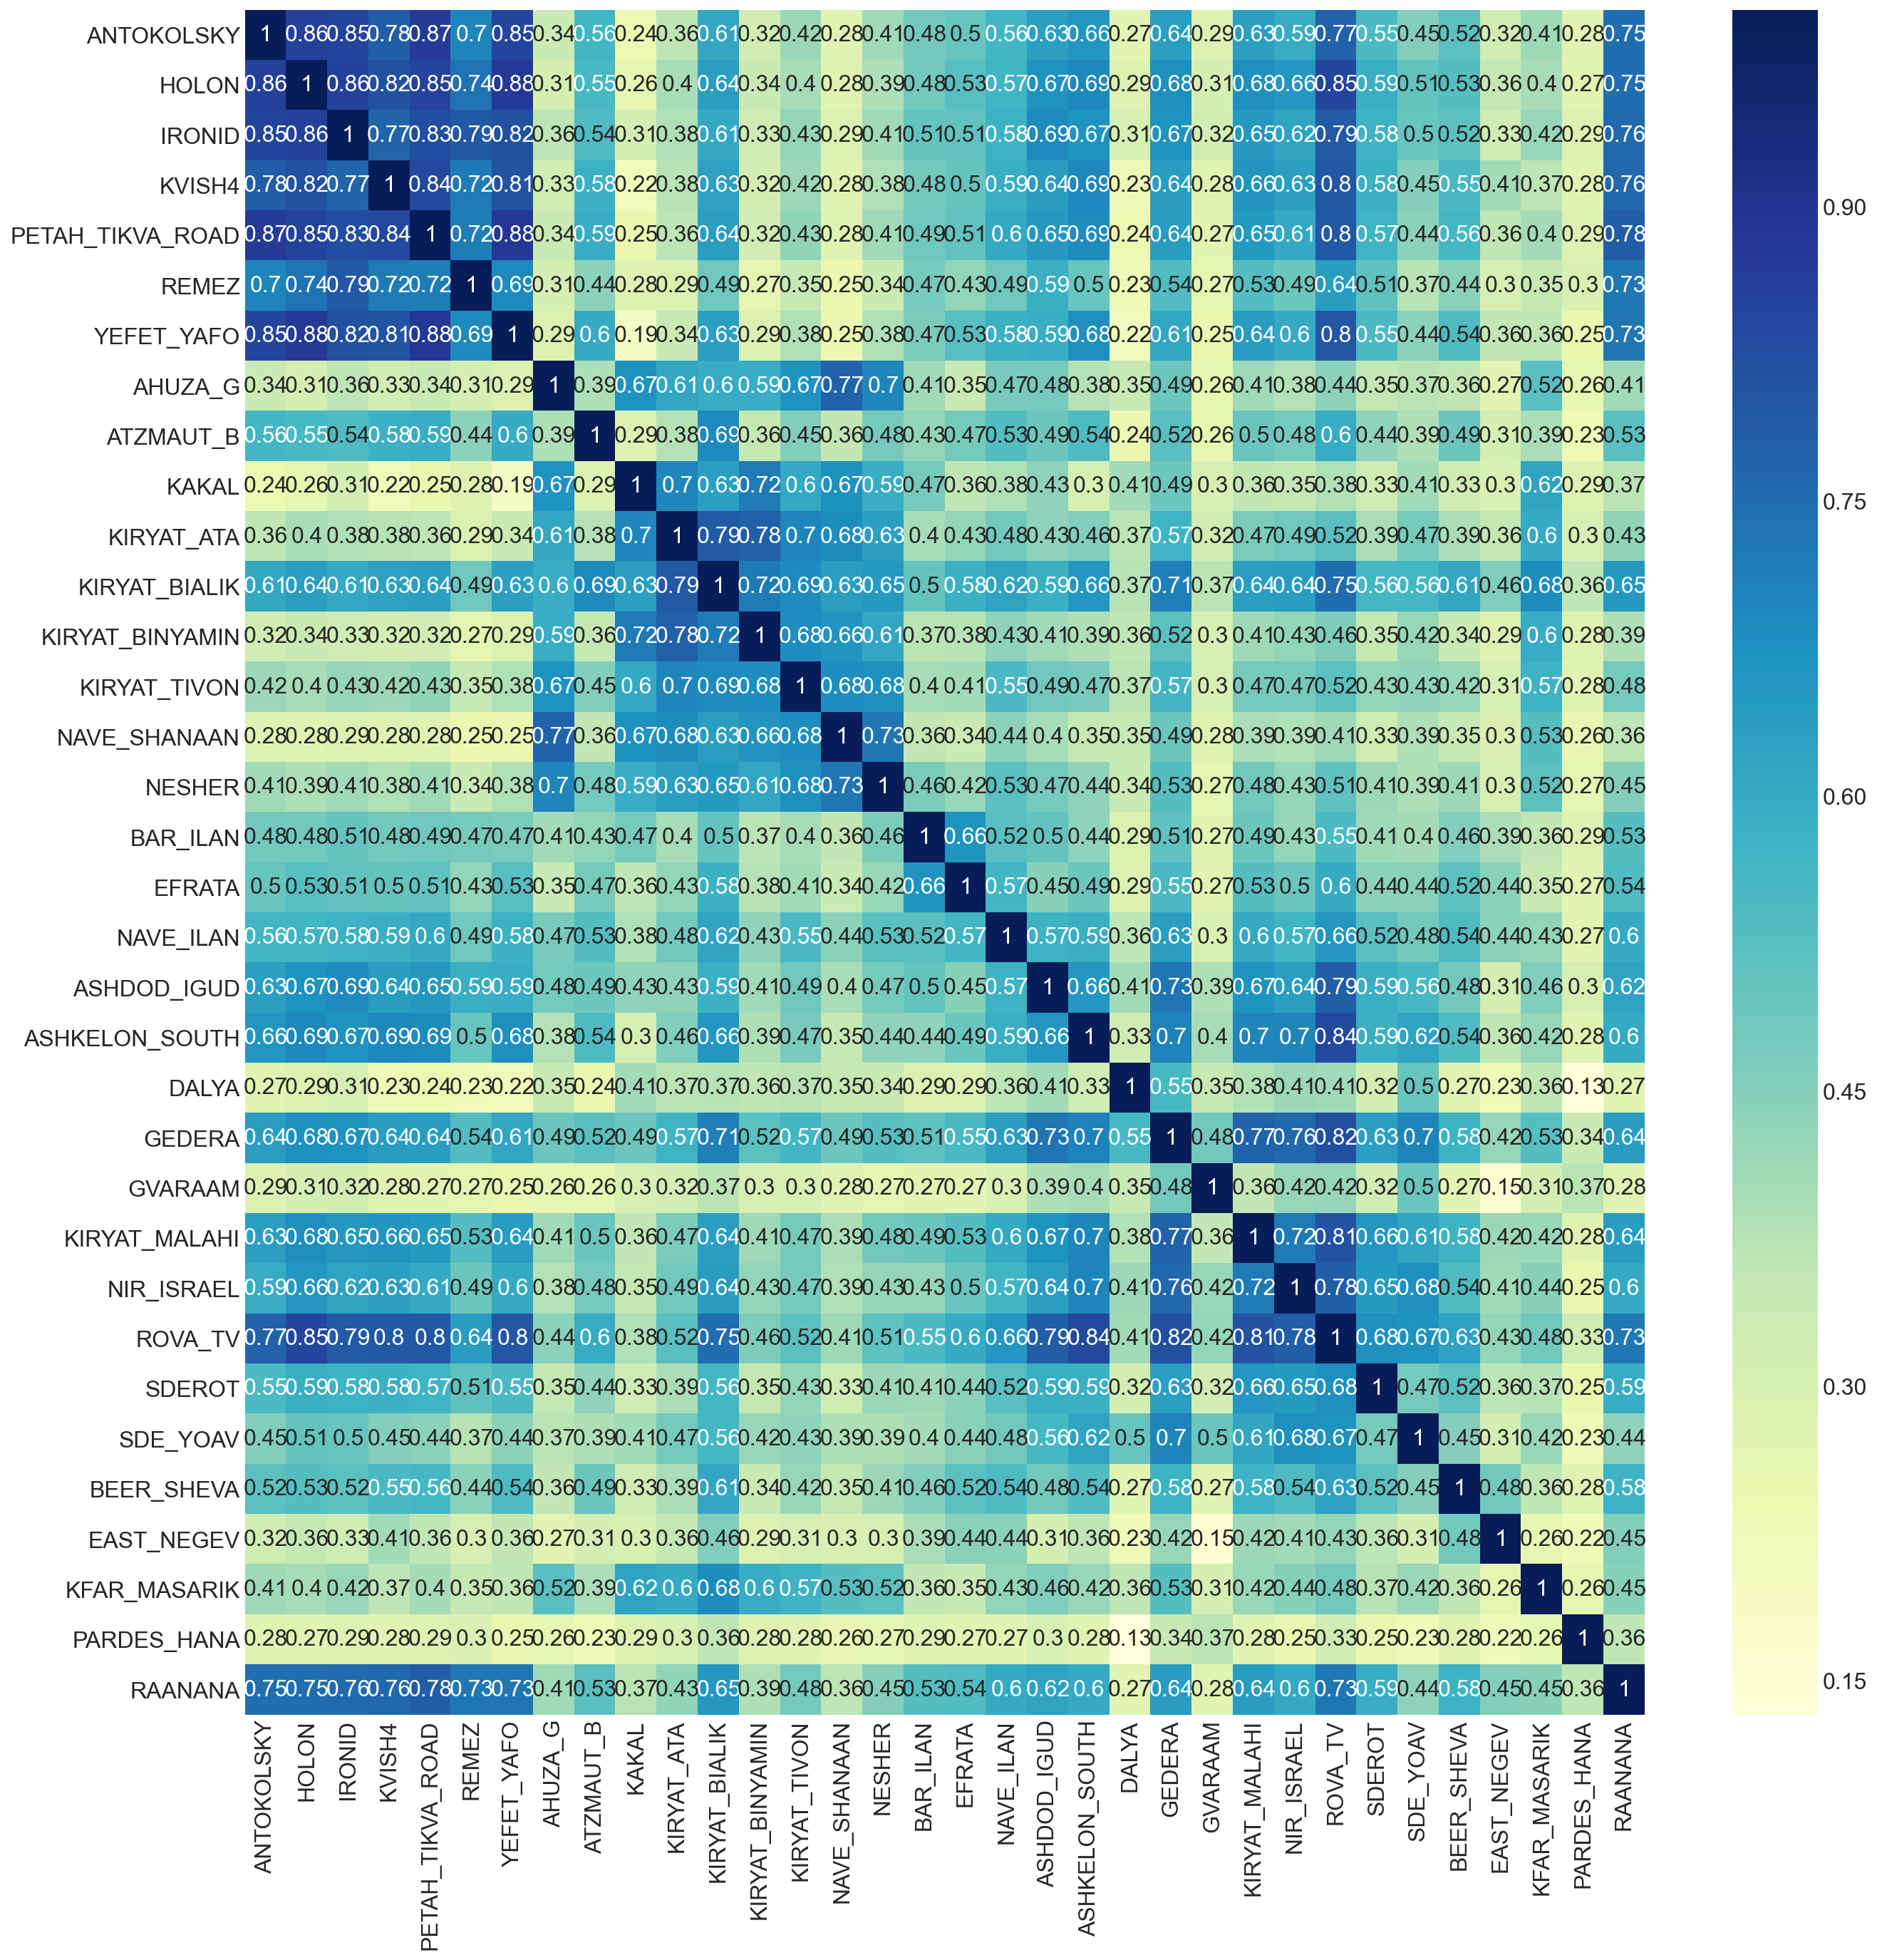

In [921]:
# fig, ax = plt.subplots(figsize=(22,22))
# sns.heatmap(temp_df_nox.corr(), cmap="YlGnBu", annot=True, vmax=1.0)
# #                 , vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
# #                 square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
# #                 )
# plt.show();

In [887]:
df_nox = df_nox.loc[ind_to_start:,STATIONS_TO_INCLUDE]

In [888]:
df_nox.reset_index(inplace=True,drop=True)

In [889]:
nox_columns = df_nox.columns
nox_columns = [i+'_NOx' for i in nox_columns.values]

In [890]:
df_nox.columns = nox_columns

In [891]:
df_nox.head(1)

,BAR_ILAN_NOx,RAANANA_NOx
0,24.9,11.1


In [892]:
pm_columns = df.columns
pm_columns = [i+'_PM25' for i in pm_columns.values]

In [893]:
df.columns = pm_columns

In [894]:
df.head(1)

,BAR_ILAN_PM25,RAANANA_PM25
0,8.1,1.9


In [895]:
total_df = pd.concat([df,df_nox],axis=1, ignore_index=True, sort=False)

In [896]:
total_df

,0,1,2,3
0,8.100000,1.900000,24.90,11.10
1,12.900000,8.500000,10.20,7.60
2,13.100000,0.100000,4.25,6.10
3,9.600000,2.200000,4.10,7.07
4,17.000000,4.000000,4.00,8.64
...,...,...,...,...
35034,16.515741,17.000000,142.10,46.00
35035,16.801944,18.200000,77.40,41.40
35036,25.299630,19.000000,111.90,44.20
35037,22.636019,24.000000,153.20,42.10


In [897]:
times = times.iloc[ind_to_start:,:]

In [898]:
# times = times[(~total_df.isnull()).all(axis=1).values]
# total_df = total_df[(~total_df.isnull()).all(axis=1).values]

In [899]:
total_df.reset_index(inplace=True)
total_df.drop(labels = 'index',axis=1, inplace=True)

times.reset_index(inplace=True)
times.drop(labels = 'index',axis=1, inplace=True)

In [900]:
# # remove dust storms in 2015
# time_condition = [((times.time>='2015-02-10 00:00:00') & (times.time<='2015-02-12 23:30:00')) | ((times.time>='2015-09-07 00:00:00') & (times.time<='2015-09-12 23:30:00'))]
# idx_to_drop = np.argwhere(time_condition)[:,1]

# total_df.drop(idx_to_drop,axis = 0, inplace=True)
# times.drop(idx_to_drop,axis = 0, inplace=True)

In [901]:
total_df.reset_index(inplace=True)
total_df.drop(labels = 'index',axis=1, inplace=True)

times.reset_index(inplace=True)
times.drop(labels = 'index',axis=1, inplace=True)

In [902]:
total_df

,0,1,2,3
0,8.100000,1.900000,24.90,11.10
1,12.900000,8.500000,10.20,7.60
2,13.100000,0.100000,4.25,6.10
3,9.600000,2.200000,4.10,7.07
4,17.000000,4.000000,4.00,8.64
...,...,...,...,...
35034,16.515741,17.000000,142.10,46.00
35035,16.801944,18.200000,77.40,41.40
35036,25.299630,19.000000,111.90,44.20
35037,22.636019,24.000000,153.20,42.10


In [903]:
times

,time
0,2018-01-01 00:30:00
1,2018-01-01 01:00:00
2,2018-01-01 01:30:00
3,2018-01-01 02:00:00
4,2018-01-01 02:30:00
...,...
35034,2019-12-31 21:30:00
35035,2019-12-31 22:00:00
35036,2019-12-31 22:30:00
35037,2019-12-31 23:00:00


In [904]:
df = total_df.copy()

In [905]:
pm_columns.extend(list(df_nox.columns.values))

In [906]:
df.columns = pm_columns

In [907]:
df.columns

Index(['BAR_ILAN_PM25', 'RAANANA_PM25', 'BAR_ILAN_NOx', 'RAANANA_NOx'], dtype='object')

In [908]:
# df.drop(['KIRYAT_BIALIK_PM25', 'KIRYAT_BIALIK_NOx'],axis=1,inplace=True)
# df.drop(['EFRATA_PM25', 'EFRATA_NOx'],axis=1,inplace=True)

In [909]:
NUM = 2
weekend_removed = False
list_of_factors = ['Factor'+str(i+1) for i in range(NUM)]

In [910]:
rs = 100

In [911]:
### Optionaly - normalize data before

# For some reason, it is not stable. possibly because I need to handle the non-positive values
# differently. maybe use MixMaxScaler transform:
# https://machinelearningmastery.com/power-transforms-with-scikit-learn/

# # option-1
# pt = PowerTransformer(method='box-cox')
# t_data = df.values + 0.0000001
# pt.fit(t_data)

# # by default applies seperately to each column
# normal_data = pd.DataFrame(pt.transform(t_data),index=df.index,columns=df.columns)

# # another option - 2
# scaler = MinMaxScaler(feature_range=(0.0000001, 10.0000001))
# power = PowerTransformer(method='box-cox')
# pipeline = Pipeline(steps=[('s', scaler),('p', power)])
# normal_data = pipeline.fit_transform(np_X_missing)

# normal_data = pd.DataFrame(
#     normal_data,
#     index=X_missing.index,
#     columns=X_missing.columns)

# another option - 3
# normal_data = pd.DataFrame(np.log(df.values+1),index=df.index,columns=df.columns)

# normal_data

In [912]:
W, H, n_iter= non_negative_factorization(df, n_components=NUM, init='nndsvd', random_state=rs, max_iter=5000)
# init = 'nndsvd' - better for sparse matrix 
# 'random' = matrices are sacled with: sqrt(X.mean() / n_components)
# 'nndsvda' | 'nndsvdar' | 'custom'
# "Ideally H will be somewhat sparse -- you would like to measure species that are, if not unique to a source, at least specific to a group of sources"

# nndsvd - ATZMAUT
# nndsvdar - BAR_ILAN

W.shape
H.shape
n_iter


(35039, 2)

(2, 4)

166

In [913]:
# another way to do the model 
# model = NMF(n_components=NUM, init='random', random_state=0, max_iter=1000)
# W = model.fit_transform(df)
# H = model.components_

In [914]:
column_names = df.columns

In [915]:
df_load = pd.DataFrame(H.T,columns=list_of_factors)
df_scores = pd.DataFrame(W, columns=list_of_factors)

In [916]:
# # scale scores and loads 
# # (it doesn't seem to influence, I guess the algorithm does that already! I should check in the function 
# # code to make sure!)
# # https://stats.stackexchange.com/questions/46469/in-non-negative-matrix-factorization-are-the-coefficients-of-features-comparabl

# sum_f1 = df_scores.iloc[:,0].sum() 
# sum_f2 = df_scores.iloc[:,1].sum() 
# df_scores.iloc[:,0] = df_scores.iloc[:,0]/sum_f1
# df_scores.iloc[:,1] = df_scores.iloc[:,1]/sum_f2

# df_load.iloc[:,0] = df_load.iloc[:,0]/sum_f1
# df_load.iloc[:,1] = df_load.iloc[:,1]/sum_f2

In [917]:
# scale scores to be in units measured? not sure since (NOx = ppb, PM = microgram/m3)
# I think there is no need to because it is just a factor.

In [918]:
%matplotlib inline

In [919]:
df_scores.shape
times.shape

(35039, 2)

(35039, 1)

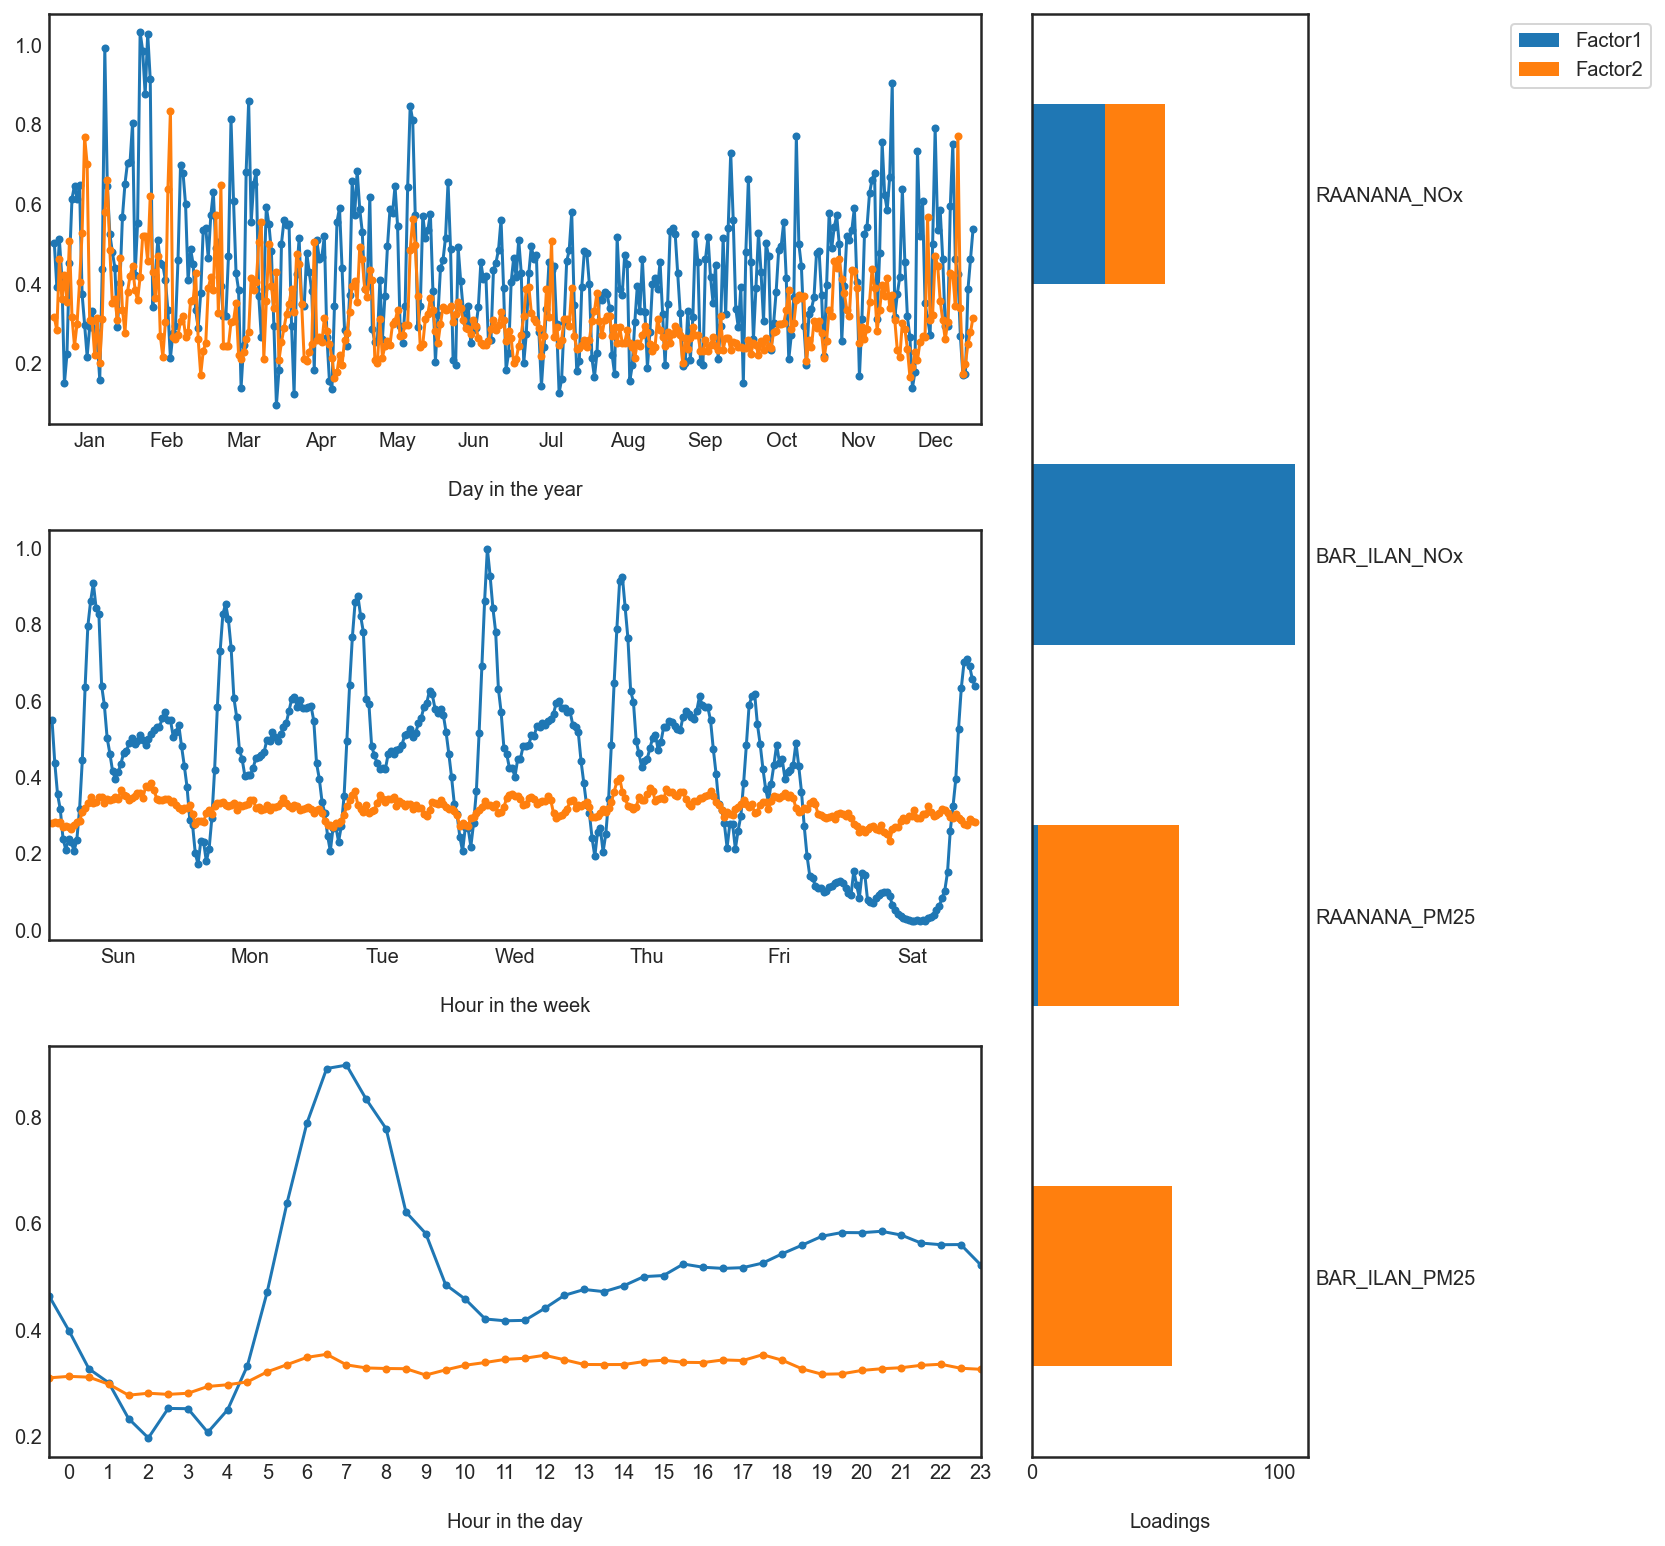

In [920]:
df_scores = add_group_columns_to_df_scores(df_scores,times)
to_save = False
plot_factors_and_loadings(df_scores, df_load, list_of_factors, column_names, weekend_removed, to_save)

In [858]:
Z0 = np.dot(df_scores.iloc[:,0],np.transpose(df_load.iloc[np.argwhere(df.columns==station+'_PM25')[0][0],0]))
Z1 = np.dot(df_scores.iloc[:,1],np.transpose(df_load.iloc[np.argwhere(df.columns==station+'_PM25')[0][0],1]))

In [859]:
Z0.mean()
np.median(Z0)

0.37505385699959903

0.3171071195034361

In [860]:
Z0

array([0.20765093, 0.08622897, 0.03937449, ..., 0.92353002, 1.26598807,
       0.53359118])

In [648]:
np.corrcoef(Z0,Z1)

array([[1.        , 0.01139909],
       [0.01139909, 1.        ]])

In [649]:
%matplotlib inline

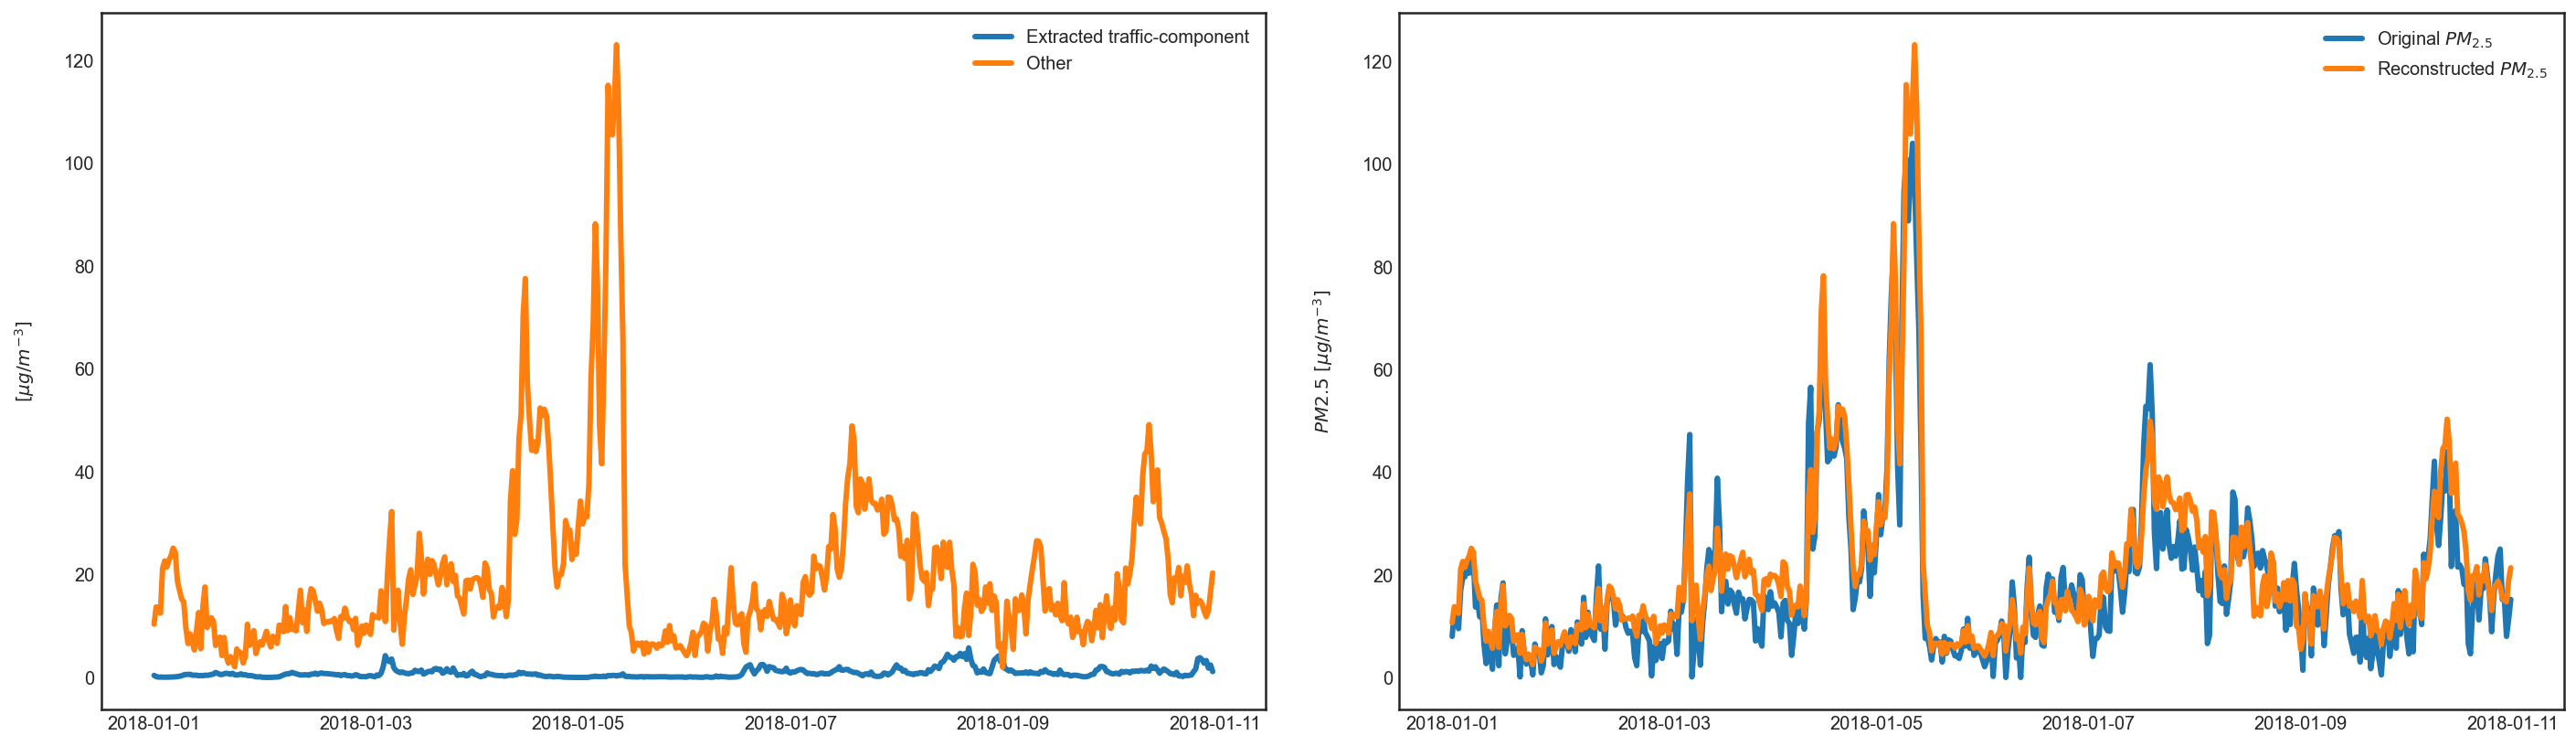

In [650]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize = (20,6))

axs[0].plot(Z0[:500],linewidth = 3)
axs[0].plot(Z1[:500],linewidth = 3)
axs[0].set_xticks(ticks = np.linspace(0,500,num=6))
axs[0].set_xticklabels(pd.to_datetime(times['time']).dt.date[np.linspace(0,500,num=6)])
axs[0].set_ylabel('$[\mu g/m^{-3}]$\n')
axs[0].legend(['Extracted traffic-component','Other'])


axs[1].plot(df[station+'_PM25'].iloc[:500].values,linewidth = 3)
axs[1].plot(Z0[:500]+Z1[:500],linewidth = 3) # should be the same as the recovered X
axs[1].set_xticks(ticks = np.linspace(0,500,num=6))
axs[1].set_xticklabels(pd.to_datetime(times['time']).dt.date[np.linspace(0,500,num=6)])
axs[1].set_ylabel('$PM 2.5~[\mu g/m^{-3}]$\n')
axs[1].legend(['Original $PM_{2.5}$','Reconstructed $PM_{2.5}$'])
# plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/reconstracted_nmf_pm.png", dpi=500)

plt.rcParams.update({'font.size': 18})
fig.tight_layout()
plt.show();

In [651]:

# plt.plot(df[station+'_PM25'].iloc[:500].values)

# plt.plot(Z0[:500]+Z1[:500]) # should be the same as the recovered X
# plt.xticks(ticks = np.linspace(0,500,num=6), labels = pd.to_datetime(times['time']).dt.date[np.linspace(0,500,num=6)])
# plt.ylabel('$PM 2.5~[\mu g/m^{-3}]$\n')
# plt.legend(['Original PM 2.5','Reconstructed PM 2.5'])
# # plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/reconstracted_nmf_pm.png", dpi=500)
# plt.show();

# Compare with BC

In [652]:
df_BC = pd.read_pickle('~/Documents/Broday/saved_data_from_notebooks/df_BC_NMF')

In [653]:
df_BC = df_BC[station]

In [654]:
df_BC.drop(df_BC.index[:ind_to_start],axis = 0, inplace=True)

In [655]:
# # removed 2015 storms, just to be on the same size
# df_BC.drop(df_BC.index[idx_to_drop],axis = 0, inplace=True)

In [656]:
df_BC

time
2018-01-01 00:30:00    0.6759
2018-01-01 01:00:00    0.7602
2018-01-01 01:30:00    0.6797
2018-01-01 02:00:00    0.6618
2018-01-01 02:30:00    0.5842
                        ...  
2019-12-31 21:30:00    4.3894
2019-12-31 22:00:00    3.5166
2019-12-31 22:30:00    4.7456
2019-12-31 23:00:00    6.3829
2019-12-31 23:30:00    7.2185
Name: BAR_ILAN, Length: 35039, dtype: float64

In [657]:
df_BC[~df_BC.isnull()].describe()

count    33104.000000
mean         2.276486
std          1.791008
min          0.053900
25%          1.109875
50%          1.874250
75%          2.895300
max         38.771700
Name: BAR_ILAN, dtype: float64

In [658]:
not_null_index = np.argwhere(~df_BC.isnull().values)

In [659]:
df_BC.shape

(35039,)

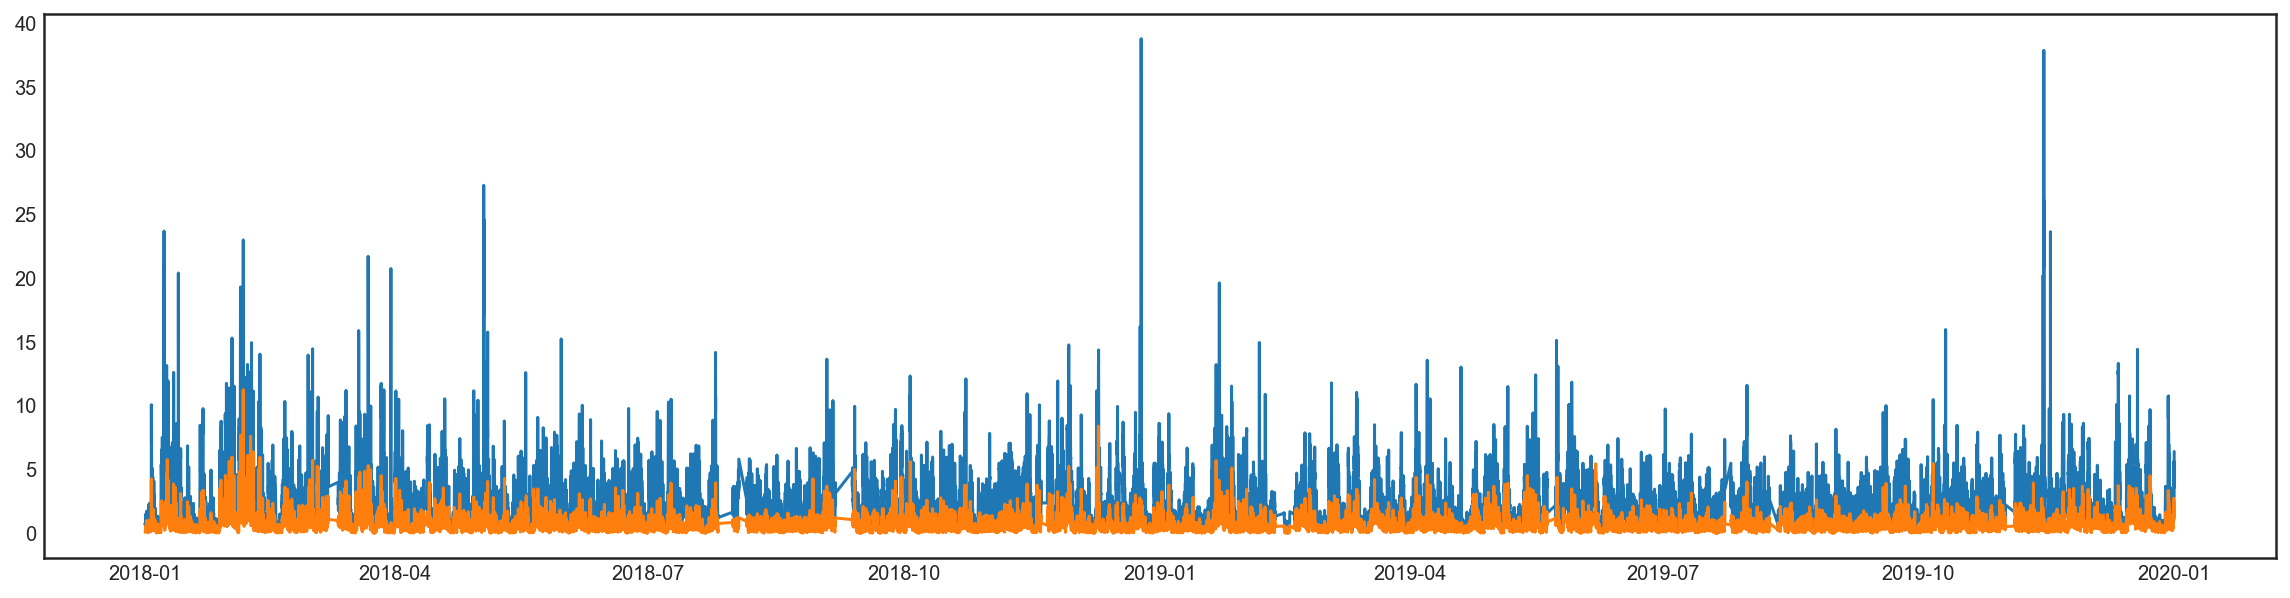

In [660]:
%matplotlib inline
ax, fig = plt.subplots(figsize = (20,5))
# ATZMAUT & BAR_ILAN
plt.plot(df_BC[~df_BC.isnull()][:-1])
plt.plot(df_BC[~df_BC.isnull()].index[:-1],Z0[not_null_index].ravel()[1:])
# plt.plot(df_BC[~df_BC.isnull()].index[:-1],lin.coef_*X[not_null_index].ravel()[1:])




In [661]:
df_BC[~df_BC.isnull()].shape

(33104,)

In [662]:
Z0[not_null_index].ravel().shape

(33104,)

In [663]:
from scipy import stats

In [664]:
np.corrcoef(df_BC[~df_BC.isnull()][:-1],Z0[not_null_index].ravel()[1:])

array([[1.        , 0.80281617],
       [0.80281617, 1.        ]])

In [665]:
stats.spearmanr(df_BC[~df_BC.isnull()][:-1],Z0[not_null_index].ravel()[1:])

SpearmanrResult(correlation=0.8401645934921923, pvalue=0.0)

In [666]:
# stats.spearmanr(df_BC[~df_BC.isnull()][:-1],lin.coef_*X[not_null_index].ravel()[1:])

In [667]:
np.mean(df_BC[~df_BC.isnull()][:-1]-Z0[not_null_index].ravel()[1:])
np.median(df_BC[~df_BC.isnull()][:-1]-Z0[not_null_index].ravel()[1:])
np.std(df_BC[~df_BC.isnull()][:-1]-Z0[not_null_index].ravel()[1:])

1.5471319439053373

1.2432652733781449

1.3232010752490482

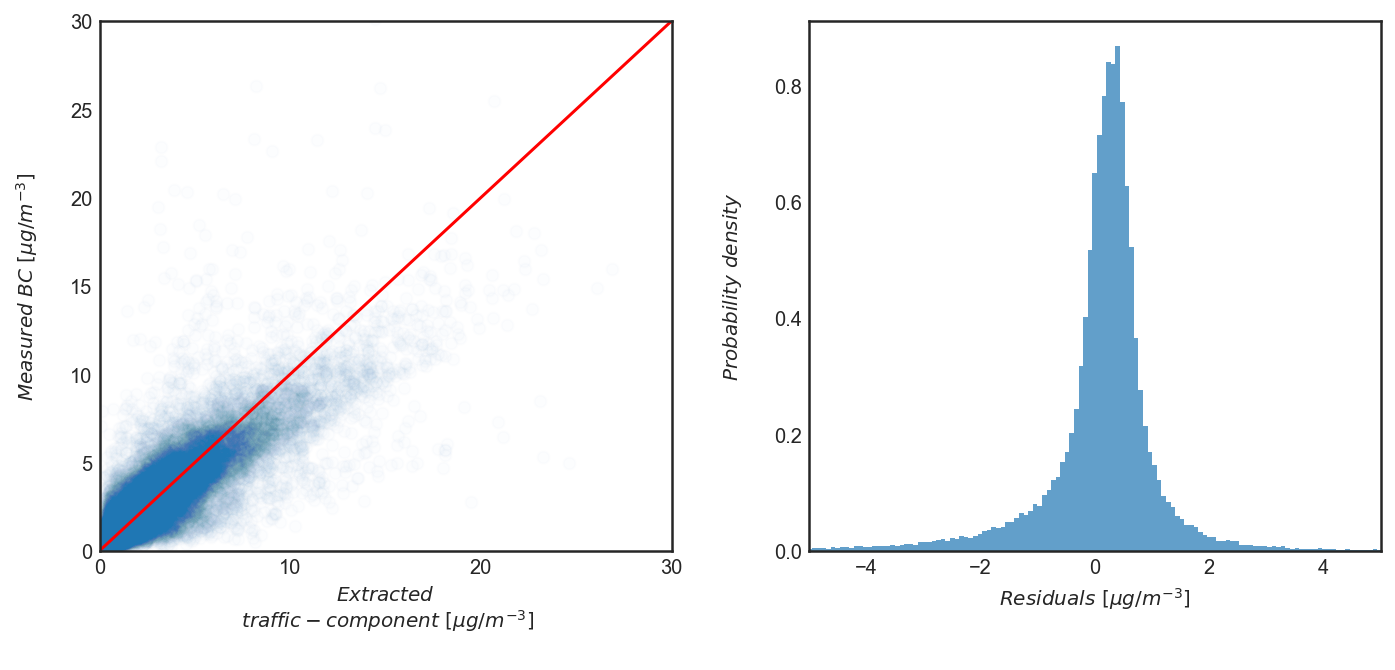

In [561]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize = (10,5))

axs[0].scatter(Z0[not_null_index].ravel()[1:],df_BC[~df_BC.isnull()][:-1],alpha=0.01)
# axs[0].scatter(df_BC[~df_BC.isnull()][:-1],lin.coef_*X[not_null_index].ravel()[1:],alpha=0.01)

axs[0].plot(np.arange(0,50),np.arange(0,50),'r')
axs[0].set_xlim(0,30)
axs[0].set_ylim(0,30)
axs[0].set_ylabel('$Measured~BC~[\mu g/m^{-3}]$\n')
axs[0].set_xlabel('$Extracted$ \n $traffic-component~[\mu g/m^{-3}]$\n')

# residulas = observed - predicted
r = df_BC[~df_BC.isnull()][:-1]-Z0[not_null_index].ravel()[1:]
# std_residulas = (observed - predicted)/std((observed - predicted))
# std_r = (r)/(np.std(r))

axs[1].hist(r,bins=700,alpha=0.7,density=True);
# axs[1].set_xlabel('$Standardized~residuals~[\mu g/m^{-3}]$\n')
axs[1].set_xlabel('$Residuals~[\mu g/m^{-3}]$\n')
axs[1].set_ylabel('$Probability~density$\n')
# plt.hist(df_BC[~df_BC.isnull()][:-1]-lin.coef_*X[not_null_index].ravel()[1:],bins=700);
axs[1].set_xlim(-5,5)

# plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/modeled_Vs_measured_BC.png", dpi=500)
plt.rcParams.update({'font.size': 16})
fig.tight_layout()
plt.show();

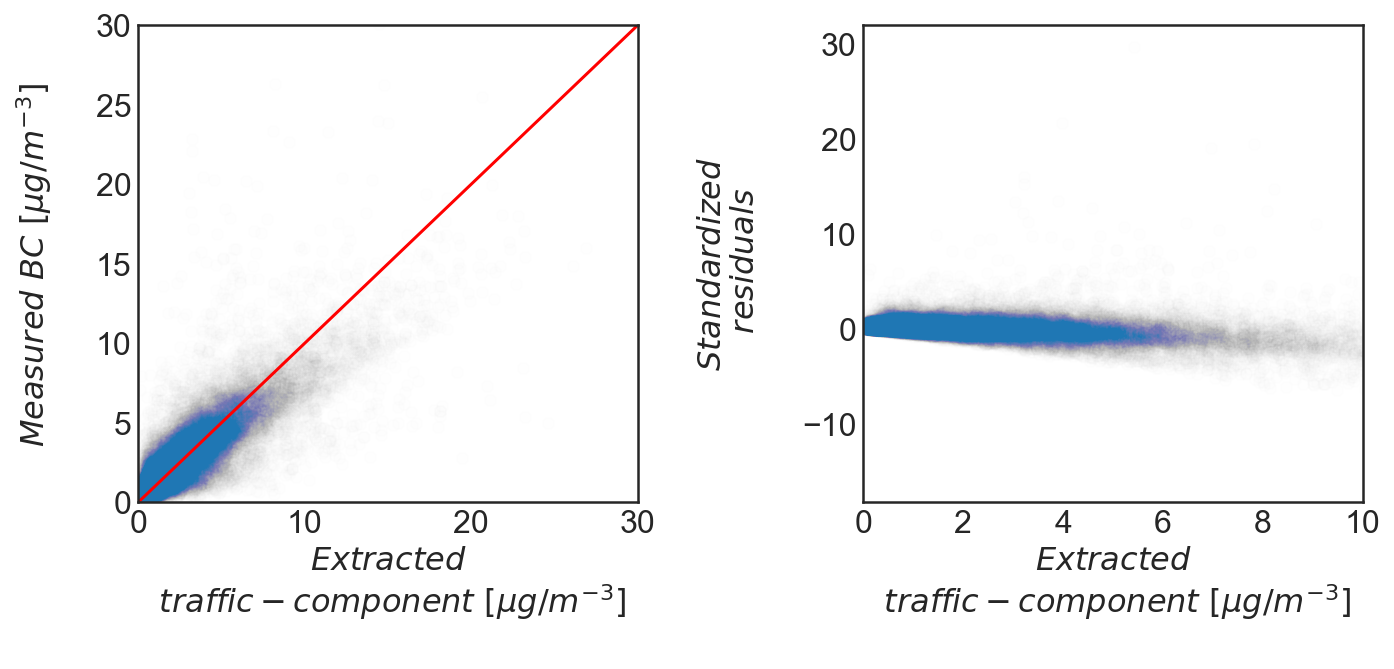

In [562]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize = (10,5))

axs[0].scatter(Z0[not_null_index].ravel()[1:],df_BC[~df_BC.isnull()][:-1],alpha=0.005)
# axs[0].scatter(df_BC[~df_BC.isnull()][:-1],lin.coef_*X[not_null_index].ravel()[1:],alpha=0.01)

axs[0].plot(np.arange(0,50),np.arange(0,50),'r')
axs[0].set_xlim(0,30)
axs[0].set_ylim(0,30)
axs[0].set_ylabel('$Measured~BC~[\mu g/m^{-3}]$\n')
axs[0].set_xlabel('$Extracted$ \n $traffic-component~[\mu g/m^{-3}]$\n')

# residulas = (observed - predicted)/std((observed - predicted))
r = df_BC[~df_BC.isnull()][:-1]-Z0[not_null_index].ravel()[1:]
# std_residulas = (observed - predicted)/std((observed - predicted))
std_r = (r)/(np.std(r))

axs[1].scatter(Z0[not_null_index].ravel()[1:],std_r,alpha = 0.002);
axs[1].set_ylabel('$Standardized$ \n $residuals$\n')
axs[1].set_xlabel('$Extracted$ \n $traffic-component~[\mu g/m^{-3}]$\n')
axs[1].set_xlim(0,10)

# plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/modeled_Vs_measured_BC.png", dpi=500)
plt.rcParams.update({'font.size': 16})
fig.tight_layout()
plt.show();

In [563]:
temp_df = pd.DataFrame(np.array([df_BC[~df_BC.isnull()][:-1].values,Z0[not_null_index].ravel()[1:]]).T,columns = ['Measured BC','Extracted traffic-component'])
# temp_df = pd.DataFrame(np.array([df_BC[~df_BC.isnull()][:-1].values,lin.coef_*X[not_null_index].ravel()[1:]]).T,columns = ['Measured BC','Extracted traffic-component'])

temp_times = pd.DataFrame(df_BC[~df_BC.isnull()][:-1])
temp_times.reset_index(level=0, inplace=True)



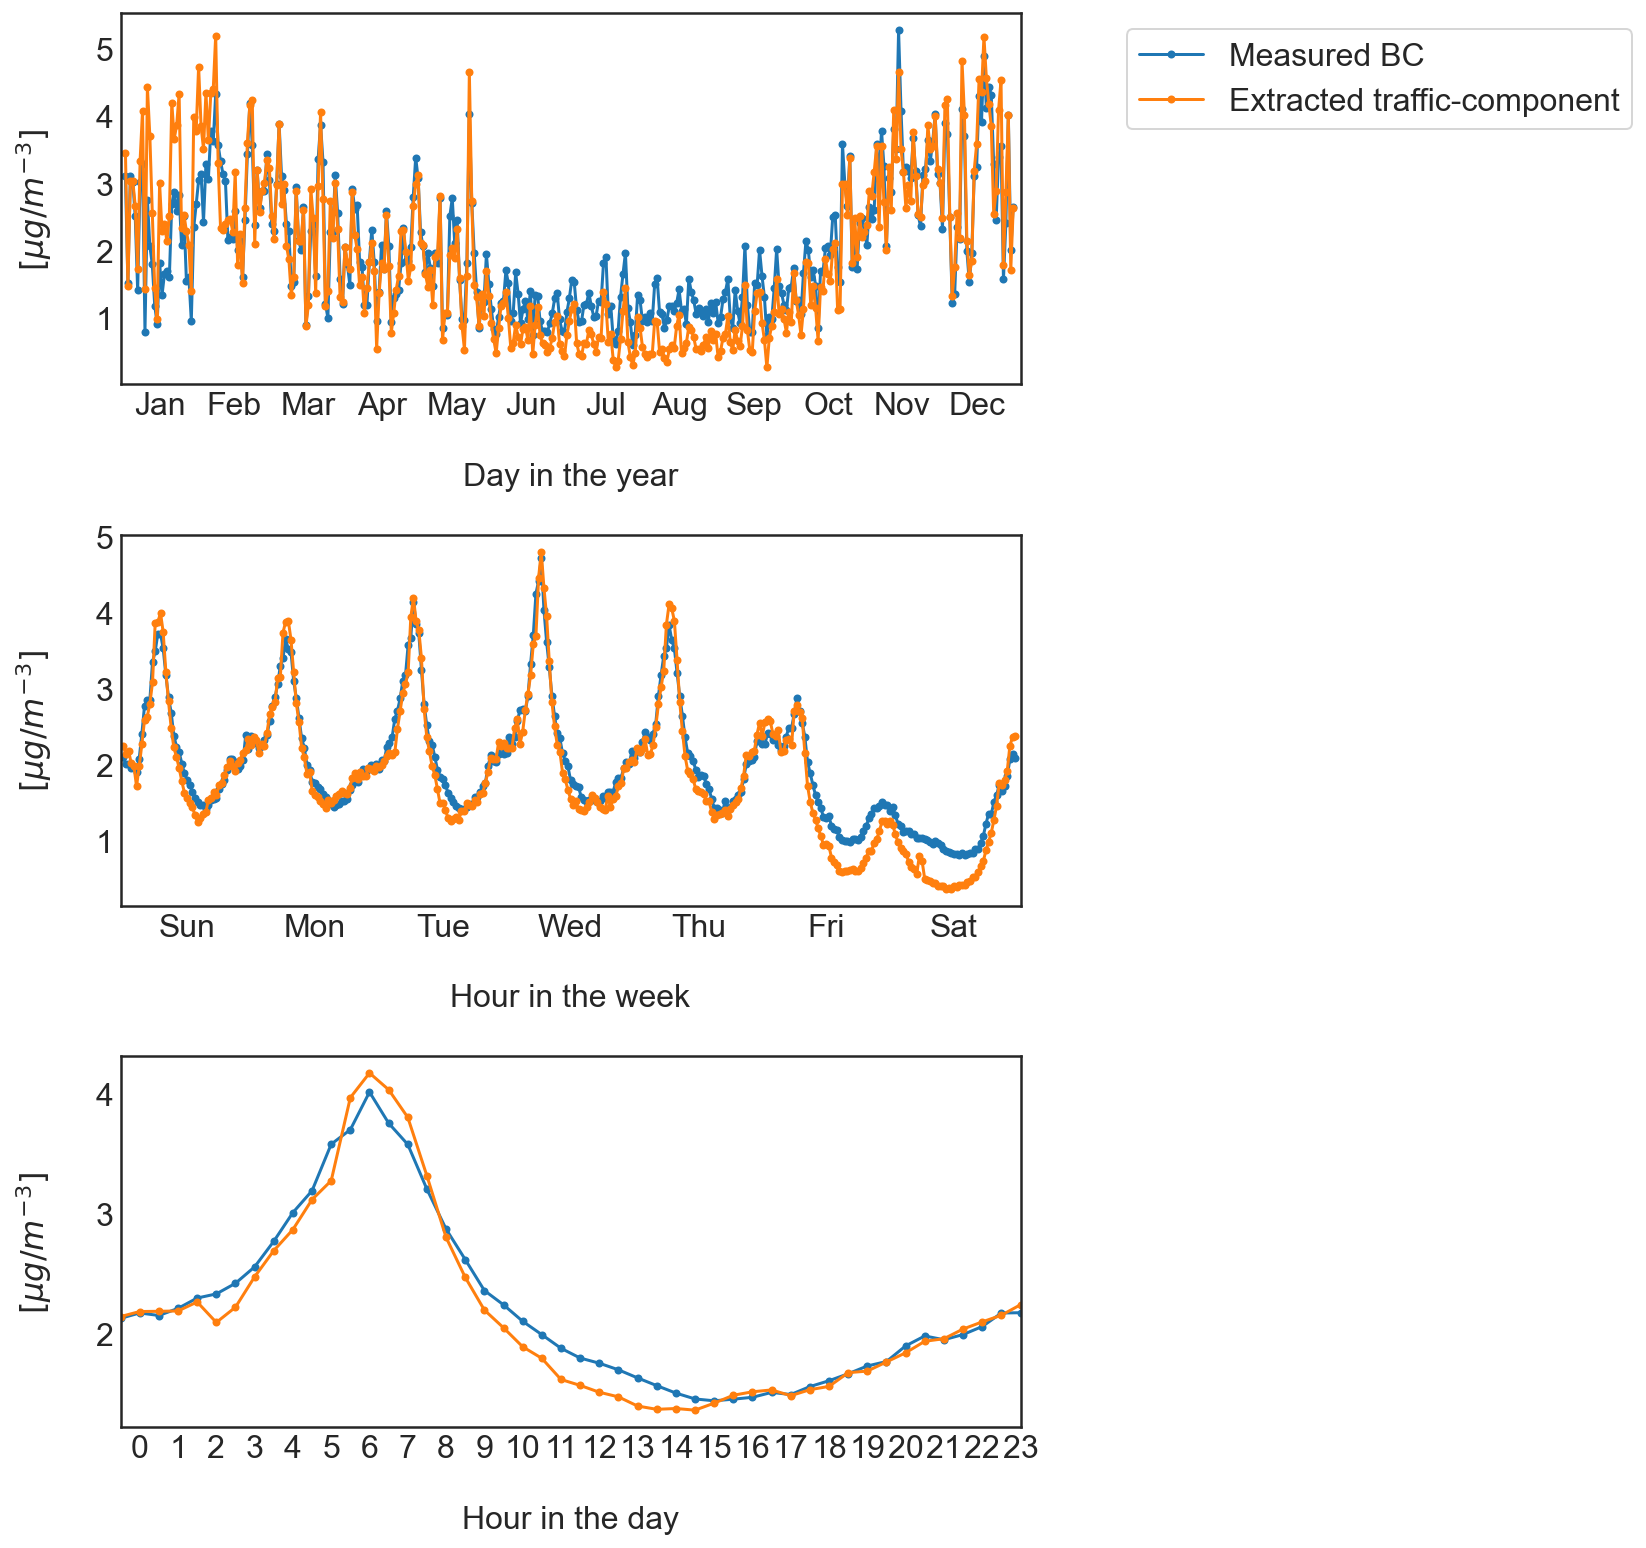

In [564]:
to_save = False
plot_time_series_sections(temp_df,['Measured BC','Extracted traffic-component'],temp_times,False,to_save)

# compare with FA - not working. FA again proves to be a qualitative tool

In [578]:
# df_Z2 = pd.read_pickle('~/Documents/Broday/saved_data_from_notebooks/TRAFFIC_FA')

In [579]:
# df_Z2

In [580]:
# df_Z2 = df_Z2['ATZMAUT_B'].values

In [581]:
# Z0.shape

In [582]:
# not_null_index

In [583]:
# fig, axs = plt.subplots(nrows=1,ncols=2,figsize = (10,5))

# axs[0].scatter(Z0[not_null_index].ravel(),df_Z2[not_null_index].ravel(),alpha=0.01)
# # axs[0].scatter(df_BC[~df_BC.isnull()][:-1],lin.coef_*X[not_null_index].ravel()[1:],alpha=0.01)

# axs[0].plot(np.arange(0,50),np.arange(0,50),'r')
# axs[0].set_xlim(0,30)
# axs[0].set_ylim(0,30)
# axs[0].set_ylabel('$Measured~BC~[\mu g/m^{-3}]$\n')
# axs[0].set_xlabel('$Extracted$ \n $traffic-component~[\mu g/m^{-3}]$\n')

# # residulas = observed - predicted
# r = df_Z2[not_null_index].ravel() - Z0[not_null_index].ravel()
# # std_residulas = (observed - predicted)/std((observed - predicted))
# # std_r = (r)/(np.std(r))

# axs[1].hist(r,bins=700,alpha=0.7,density=True);
# # axs[1].set_xlabel('$Standardized~residuals~[\mu g/m^{-3}]$\n')
# axs[1].set_xlabel('$Residuals~[\mu g/m^{-3}]$\n')
# axs[1].set_ylabel('$Probability~density$\n')
# # plt.hist(df_BC[~df_BC.isnull()][:-1]-lin.coef_*X[not_null_index].ravel()[1:],bins=700);
# axs[1].set_xlim(-5,5)

# # plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/modeled_Vs_measured_BC.png", dpi=500)
# plt.rcParams.update({'font.size': 16})
# fig.tight_layout()
# plt.show();

In [576]:
# temp_df = pd.DataFrame(np.array([Z0[not_null_index].ravel(),df_Z2[not_null_index].ravel()]).T,columns = ['Measured BC','Extracted traffic-component'])

# temp_times = pd.DataFrame(df_BC[~df_BC.isnull()])
# temp_times.reset_index(level=0, inplace=True)

In [584]:
# to_save = False
# plot_time_series_sections(temp_df,['Measured BC','Extracted traffic-component'],temp_times,False,to_save)

# Compare with non-negative least squares

In [412]:
y = df['ATZMAUT_B_PM25'].values
X = df['ATZMAUT_B_NOx'].values.reshape(-1, 1)

# y = df['BAR_ILAN_PM25'].values
# X = df['BAR_ILAN_NOx'].values.reshape(-1, 1)

In [413]:
# scipy.optimize.nnls

In [414]:


lin = Lasso(alpha=0.00001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random')
lin.fit(X,y)

Lasso(alpha=1e-05, positive=True, precompute=True, random_state=9999,
      selection='random')

In [415]:
lin.coef_

array([0.07721998])

In [416]:
lin.coef_*X

array([[ 5.88416245],
       [ 7.76060795],
       [10.70268917],
       ...,
       [13.66021439],
       [13.47488644],
       [ 2.55752572]])

In [417]:
# with zero regularization I got not good results. why?

## Maybe it is better to try and predict the relashionship between NOx and BC and just ?
would be problematic since not many BC and no reason to think it will hold to predict in another geographic location

# impute SO2 series

# GENERATE a sub-df of SO2 and concat to PM2.5

# Cannot compare it with anything... ? 